In [1]:
import sklearn
import seaborn as sns
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt

Q1: Exploratory Data Analysis (5 Pts)

Get familiar with the dataset by exploring the different features, their distribution, and the labels. Check for common pitfalls like missing or nonsensical data, unusual feature distribution, outliers, or class imbalance, and describe how to handle them. After having familiarized yourself with the data, explain how you preprocess the dataset for the remaining tasks of part 1. Interpretability
     
and explainability aim at gaining more insights about the data than just optimizing predictive performance. A first simple step is to have a look at the (linear) dependencies of the variables. Visualize the pairwise correlation matrix and describe which features seem to be important for predicting the label.

In [2]:
df = pd.read_csv("train_val_split.csv")

df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
2,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
3,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
4,39,M,NAP,120,339,0,Normal,170,N,0.0,Up,0


In [3]:
for i in df.columns:
    print(i , df[i].nunique())

Age 49
Sex 2
ChestPainType 4
RestingBP 64
Cholesterol 204
FastingBS 2
RestingECG 3
MaxHR 115
ExerciseAngina 2
Oldpeak 50
ST_Slope 3
HeartDisease 2


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,734.0,53.523161,9.421110,29.0,47.00,54.0,60.0,77.0
RestingBP,734.0,132.062670,18.618490,0.0,120.00,130.0,140.0,200.0
Cholesterol,734.0,197.588556,108.979439,0.0,172.25,222.0,267.0,529.0
FastingBS,734.0,0.232970,0.423012,0.0,0.00,0.0,0.0,1.0
MaxHR,734.0,136.167575,25.334552,60.0,120.00,138.0,155.0,195.0
Oldpeak,734.0,0.873978,1.082222,-2.0,0.00,0.5,1.5,6.2
HeartDisease,734.0,0.542234,0.498553,0.0,0.00,1.0,1.0,1.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 734 entries, 0 to 733
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             734 non-null    int64  
 1   Sex             734 non-null    object 
 2   ChestPainType   734 non-null    object 
 3   RestingBP       734 non-null    int64  
 4   Cholesterol     734 non-null    int64  
 5   FastingBS       734 non-null    int64  
 6   RestingECG      734 non-null    object 
 7   MaxHR           734 non-null    int64  
 8   ExerciseAngina  734 non-null    object 
 9   Oldpeak         734 non-null    float64
 10  ST_Slope        734 non-null    object 
 11  HeartDisease    734 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 68.9+ KB


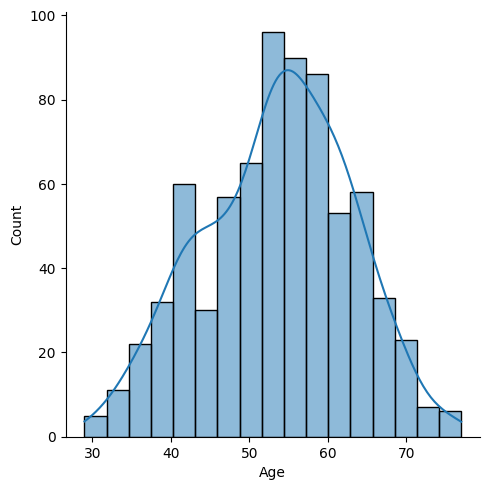

In [6]:
sns.displot(df['Age'] , kde = True)

<Axes: >

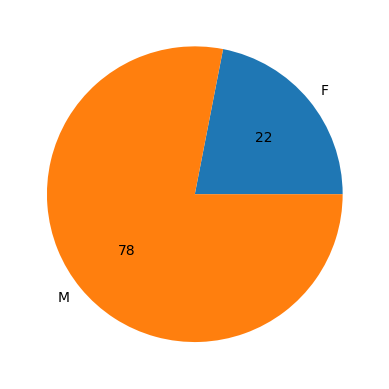

In [7]:
df.groupby('Sex').size().plot(kind = 'pie' , autopct = '%.0f')

Correlation

In [8]:
df.corr()

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
Age,1.000000,0.240539,-0.125336,0.199419,-0.373784,0.262889,0.294751
RestingBP,0.240539,1.000000,0.105258,0.102769,-0.110562,0.166465,0.101420
Cholesterol,-0.125336,0.105258,1.000000,-0.253459,0.234045,0.049687,-0.253538
FastingBS,0.199419,0.102769,-0.253459,1.000000,-0.090212,0.061538,0.254086
MaxHR,-0.373784,-0.110562,0.234045,-0.090212,1.000000,-0.171323,-0.405552
Oldpeak,0.262889,0.166465,0.049687,0.061538,-0.171323,1.000000,0.420891
HeartDisease,0.294751,0.101420,-0.253538,0.254086,-0.405552,0.420891,1.000000


The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


<Axes: >

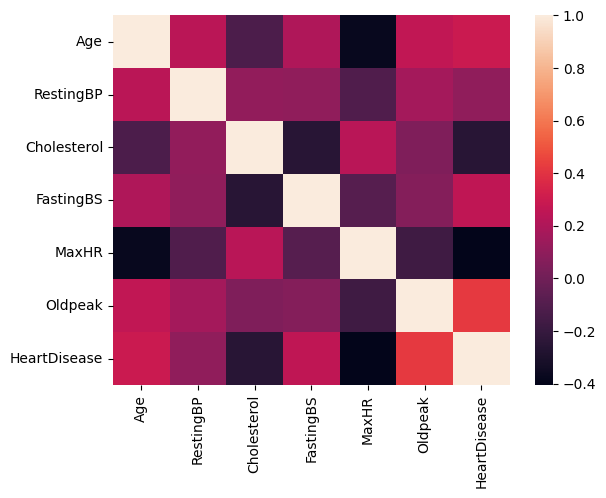

In [9]:
sns.heatmap(df.corr())

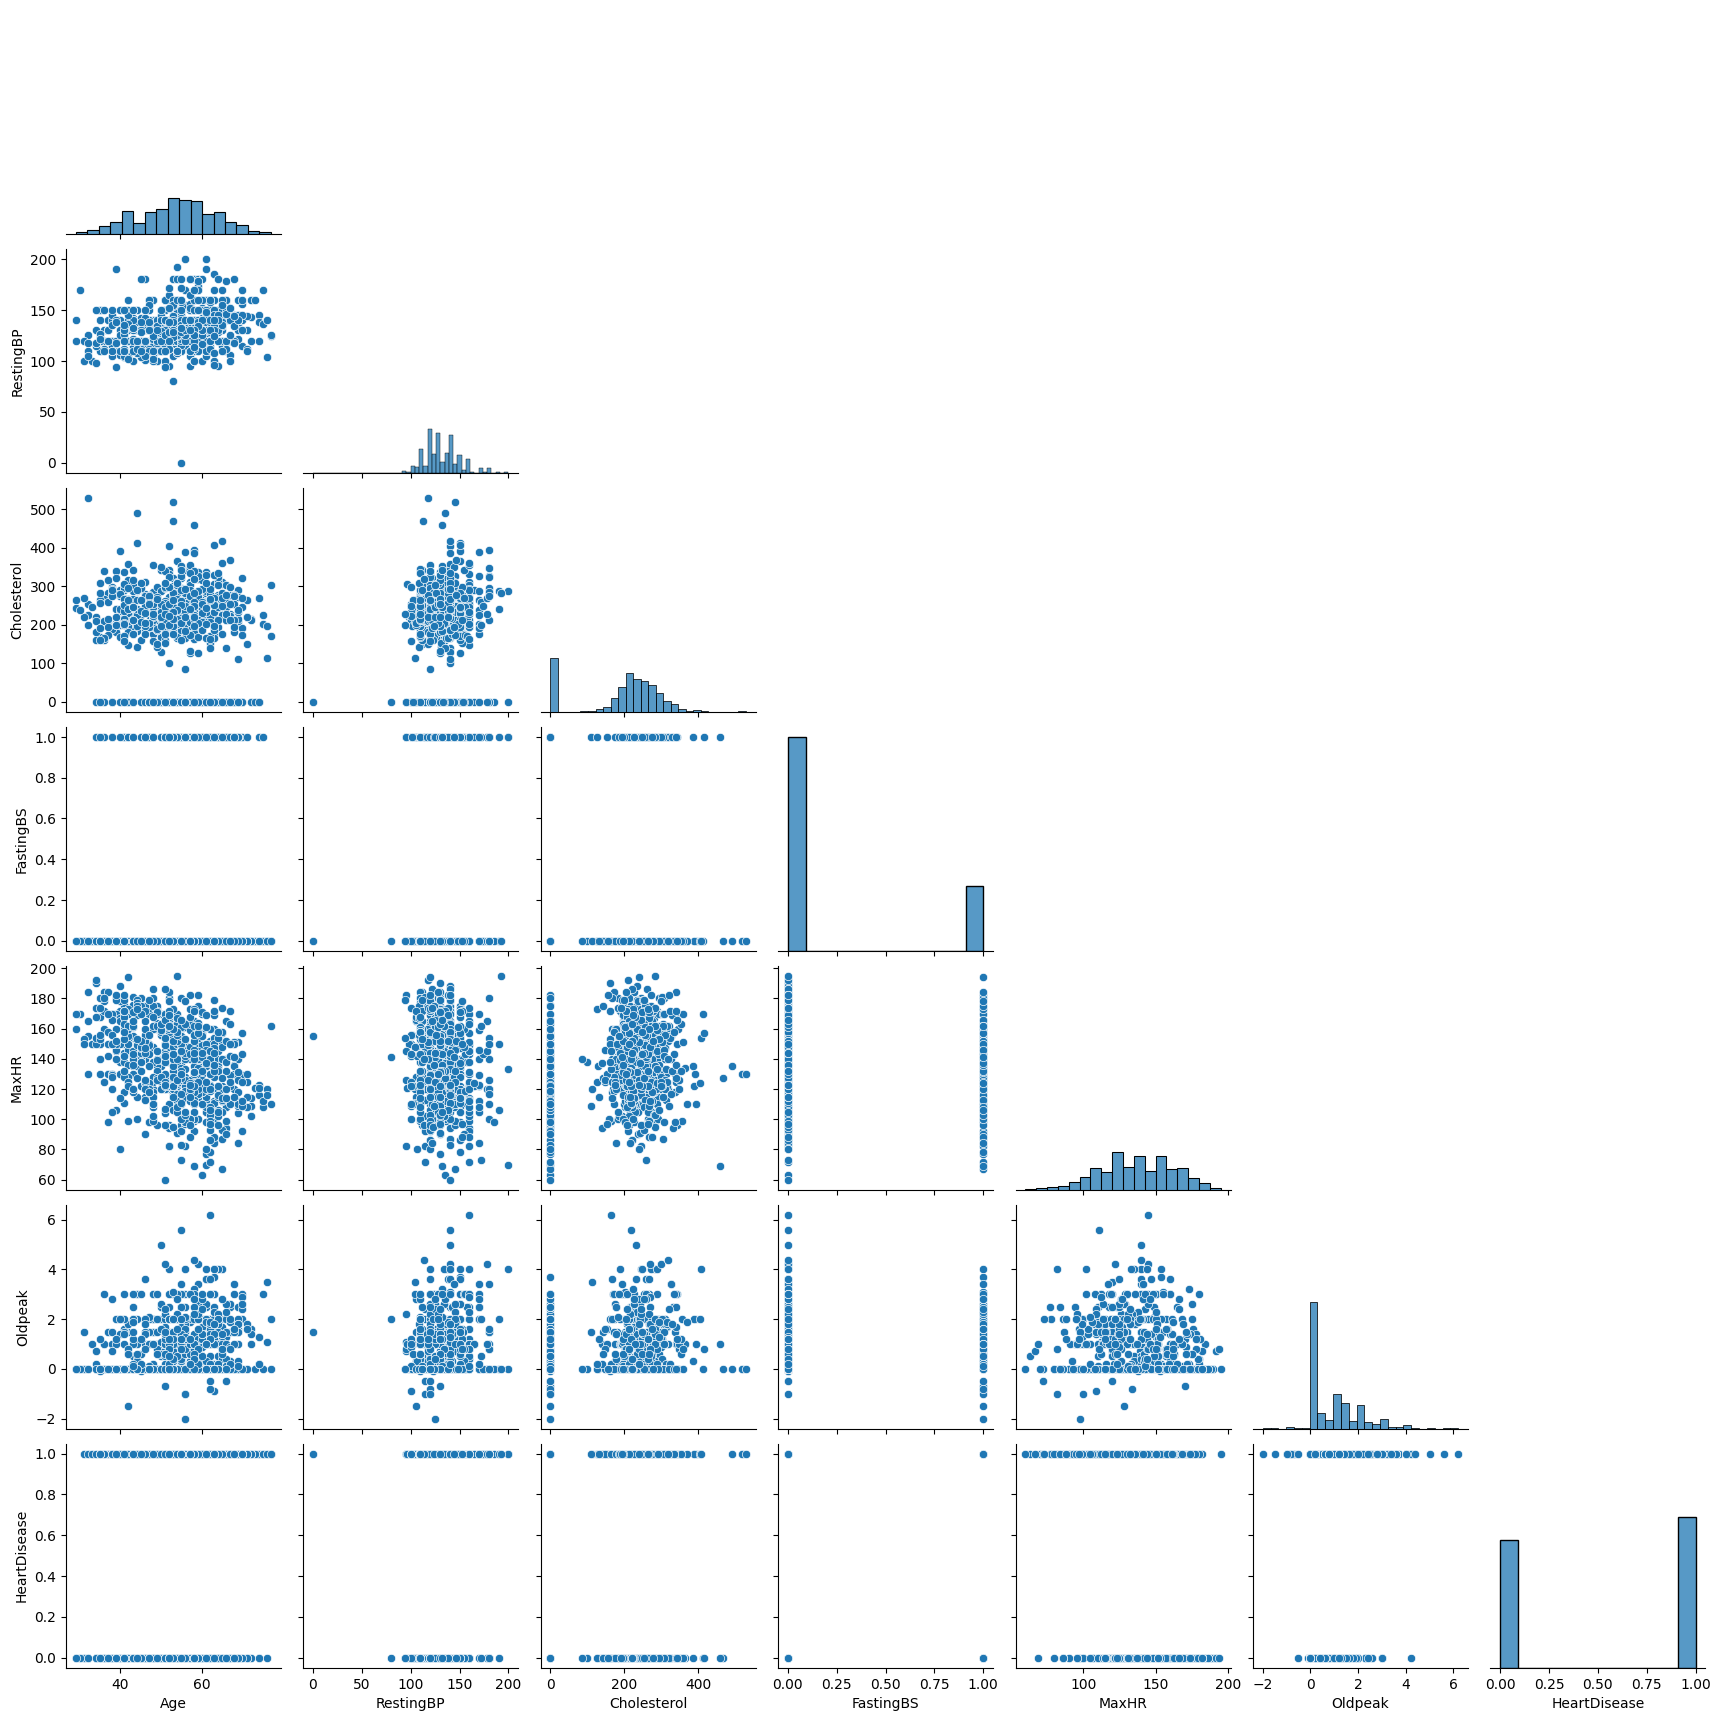

In [10]:
#sns.pairplot(df)
sns.pairplot(df,corner=True)

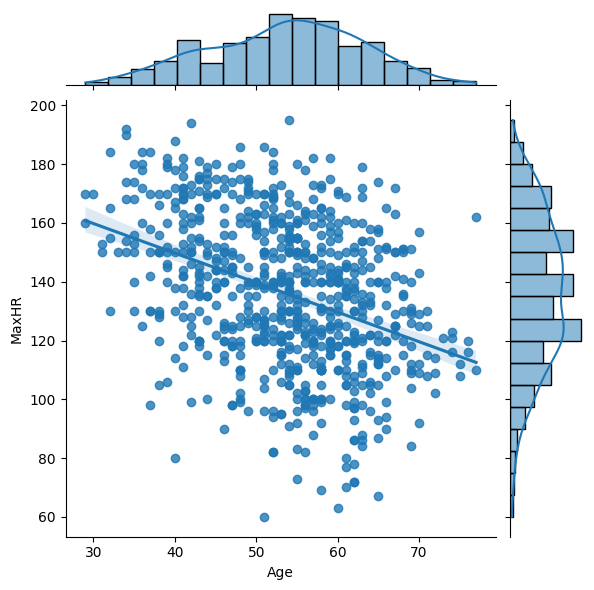

In [11]:
sns.jointplot(x = 'Age',y = 'MaxHR',data = df,kind = 'reg')

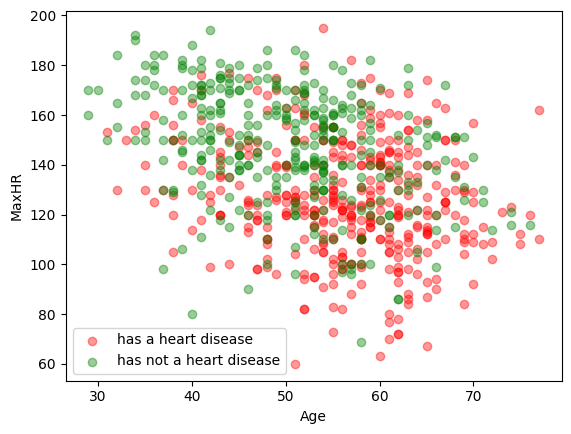

In [12]:
# yes = heart disease, no = has not a heart disease
yes = df[df.HeartDisease == 1]
no = df[df.HeartDisease == 0]

# Compare of Age and MaxHR
plt.scatter(yes.Age,yes.MaxHR,color='red',label='has a heart disease',alpha=0.4)
plt.scatter(no.Age,no.MaxHR,color='green',label='has not a heart disease',alpha=0.4)
plt.xlabel("Age")
plt.ylabel("MaxHR")
plt.legend()
plt.show()

Q2: Logistic Lasso Regression (5 Pts)

By design, linear models are interpretable due to the weights that intuitively provide feature importance values. Further, we can perform l1 regularization to sparsify weights, allowing us to understand which features do not contribute to the outcome. For this question, fit a Lasso regression model with l1 regularization on the dataset. What preprocessing step is crucial to ensure comparability of feature coefficients? Provide performance metrics such as f1-score or balanced accuracy to quantify the performance of this model. Visualize the importance of the different features and present how they contribute to the model's output. Finally, argue for or against fitting a logistic regression using only the important variables, as determined by the Lasso model, to arrive at the final coefficients instead of keeping the coefficients of the Lasso model.

In [13]:
# One Hot Encoding
string_col = df.select_dtypes(include="object").columns

df_ohe = pd.get_dummies(df,columns=string_col,drop_first=False)

In [14]:
df_ohe.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,...,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,0,1,0,...,0,0,0,1,0,1,0,0,0,1
1,37,130,283,0,98,0.0,0,0,1,0,...,0,0,0,0,1,1,0,0,0,1
2,48,138,214,0,108,1.5,1,1,0,1,...,0,0,0,1,0,0,1,0,1,0
3,54,150,195,0,122,0.0,0,0,1,0,...,1,0,0,1,0,1,0,0,0,1
4,39,120,339,0,170,0.0,0,0,1,0,...,1,0,0,1,0,1,0,0,0,1


In [15]:
# Definition
y = df_ohe.HeartDisease.values
x_pre = df_ohe.drop(['HeartDisease'],axis=1)
x_pre.shape

(734, 20)

In [16]:
# Normalization
x = (x_pre - np.min(x_pre))/(np.max(x_pre) - np.min(x_pre))
x.shape

In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'


(734, 20)

In [17]:
# train test split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y,test_size = 0.2,random_state=25)

In [18]:
x_train.shape

(587, 20)

In [19]:
# LogisticRegression
from sklearn.linear_model import LogisticRegression

# Model
lr = LogisticRegression(penalty="l1", C=1, tol=0.01, solver="saga")

# Train
lr.fit(x_train,y_train)

y_pred = lr.predict(x_test)

In [20]:
# Accuracy
print("Accuracy of Logistic Regression: {}\n".format(lr.score(x_test,y_test)))

# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_pred)
print("Confusion matrix of loigistic regression:\n {}".format(cm))

Accuracy of Logistic Regression: 0.891156462585034

Confusion matrix of loigistic regression:
 [[58  7]
 [ 9 73]]


Q3: Decision Trees (3 Pts)

Like linear models, decision trees are intrinsically interpretable models by nature. For a given output, we can retrace every decision that led to the final prediction by following the path of a sample along the edges of the tree. Further, the models' impurity measure allows us to quantify feature importance within the dataset. As in the previous question, train a decision tree on the dataset and report classification performance on the test set. Visualize the influence of the different features according to the Gini importance.

In [21]:
# Label Encoding For Tree Based Algorithms
from sklearn.preprocessing import LabelEncoder

df_tree = df.apply(LabelEncoder().fit_transform)
df_tree.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,11,1,1,39,138,0,1,97,0,8,2,0
1,8,1,1,29,133,0,2,24,0,8,2,0
2,19,0,0,37,64,0,1,33,1,23,1,1
3,25,1,2,47,45,0,1,47,0,8,2,0
4,10,1,2,21,177,0,1,95,0,8,2,0


In [22]:
# Definition
y = df_tree.HeartDisease.values
x_data = df_tree.drop(['HeartDisease'],axis=1)

# Normalization
x = (x_data - np.min(x_data))/(np.max(x_data) - np.min(x_data))
x.shape

In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'


(734, 11)

In [23]:
# train test split
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=1)

In [24]:
# Classifier
from sklearn.tree import DecisionTreeClassifier

# Model
dt = DecisionTreeClassifier()

# Train
dt.fit(x_train,y_train)

y_pred = dt.predict(x_test)

In [25]:
# Accuracy
print("Accuracy of Decision Tree: {}\n".format(dt.score(x_test,y_test)))

# Confusion matrix
cm = confusion_matrix(y_test,y_pred)
print("Confusion matrix of Decision Tree:\n {}".format(cm))

Accuracy of Decision Tree: 0.8095238095238095

Confusion matrix of Decision Tree:
 [[52 15]
 [13 67]]


Q4: Multi-Layer Perceptrons(7 Pts)

While often reaching superior performance, MLPs are generally hard to interpret, and it is not straightforward to see what is happening within these models. We thus opt for post-hoc explainability methods such as SHAP1. Post-hoc explainability methods typically use some procedure during inference to find the feature importance per sample. Similar to Q2 and Q3, implement a simple MLP, train it on the dataset, and report test set performance. Make sure to report the architecture and optimization procedure you used for training.
Further, visualize SHAP explanations of the outputs of four positive and negative samples and feature importances of the overall model. Are feature importances consistent across different predictions and compared to overall importance values? Elaborate on your findings!
Hint: There is an excellent SHAP library for python that provides many SHAP algorithms and visualizations out of the box.

In [26]:
# Definition
y = df_ohe.HeartDisease.values
x = df_ohe.drop(['HeartDisease'],axis=1)

# train test split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state=1)

In [27]:
# Classifier
from sklearn.neural_network import MLPClassifier

# Model
mlp = MLPClassifier(hidden_layer_sizes=(100, 50), learning_rate='adaptive', max_iter=2000) # learning rate, hidden layer size

In [28]:
# Train
mlp.fit(x_train,y_train)

# kernel always crashes???

: 

: 

In [ ]:
y_pred = mlp.predict(x_test)

# Accuracy
print("Accuracy of Decision Tree: {}\n".format(mlp.score(x_test,y_test)))

# Confusion matrix
cm = confusion_matrix(y_test,y_pred)
print("Confusion matrix of Decision Tree:\n {}".format(cm))

Interpretability

In [ ]:
# Create object that can calculate shap values
explainer = shap.DeepExplainer(mlp)

# Calculate Shap values
shap_values = explainer.shap_values(x_test)

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], x_test)
